## Weather data and graphs
For the project, two weatherfiles were used which were collected from energyplus. 
The first weatherfile is for Lyon-Bron, France: FRA_Lyon.074810_IWEC.epw
In order to validate the results, simulations were also run with a weatherfile for Beijing, China: CHN_Beijing.Beijing.545110_IWEC.epw

The following section describes the creation of weather graphs which were utilized to verify the model and evaluate its' response to fluctuations in temperature. 

## 1. Plotting outdoor temperature
In order to evaluate the model's calculation of heating and cooling. A week was searched for which would require both heating and cooling. Firstly, the outdoor temperature during the whole year was plotted for Lyon-Bron: 


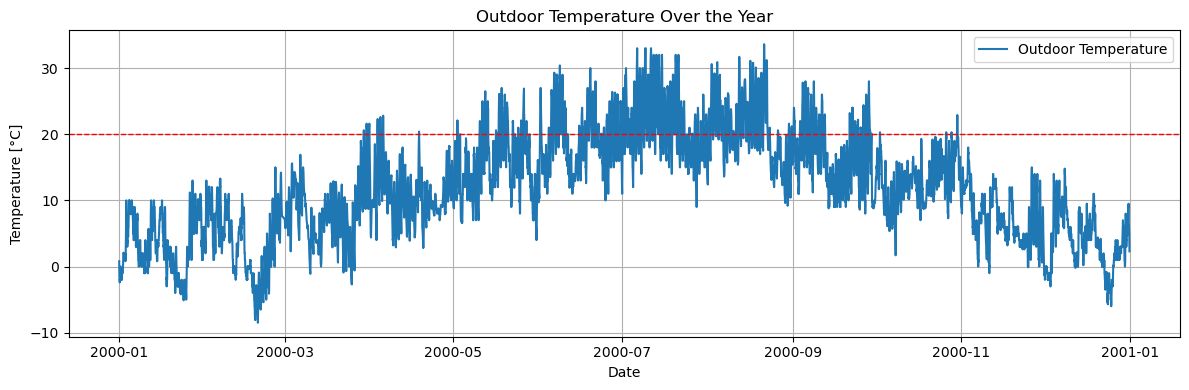

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#%% yearly 

input_data_proj = pd.read_csv("input_data_proj.csv", index_col=0, parse_dates=True)

# Plot the outdoor temperature 
plt.figure(figsize=(12, 4))
plt.plot(input_data_proj.index, input_data_proj['To'], label='Outdoor Temperature', color='tab:blue')
plt.ylabel('Temperature [°C]')
plt.xlabel('Date')
plt.title('Outdoor Temperature Over the Year')
plt.grid(True)
plt.legend()

# Add horizontal line at indoor setpoint 20°C
plt.axhline(y=20, color='red', linestyle='--', linewidth=1, label='20 °C')
plt.tight_layout()
plt.show()

It was noted that the Month of May contained temperatures above and below 20 degrees and the model woul require both cooling and heating. 
Therefore, the outdoor temperature for the month of May was plotted: 

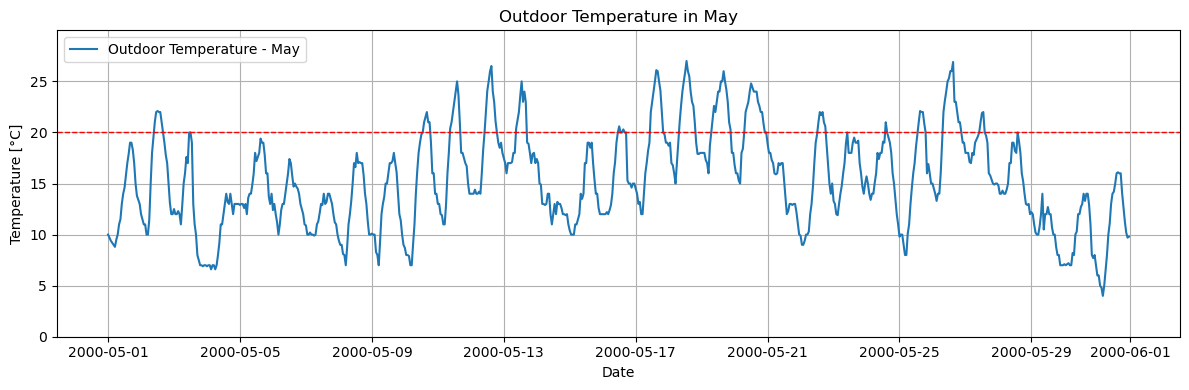

In [8]:
#%% Monthly

# Read the CSV
input_data_proj = pd.read_csv("input_data_proj.csv", index_col=0, parse_dates=True)

# Filter for May (month == 5)
may_data = input_data_proj[input_data_proj.index.month == 5]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(may_data.index, may_data['To'], label='Outdoor Temperature - May', color='tab:blue')
plt.ylabel('Temperature [°C]')
plt.xlabel('Date')
plt.title('Outdoor Temperature in May')
plt.grid(True)
plt.legend()

# Add horizontal line at indoor setpoint 20°C
plt.axhline(y=20, color='red', linestyle='--', linewidth=1, label='20 °C')

# Fix y-axis scale: ticks from 0 to 40 in steps of 5
plt.ylim(0, 30)
plt.yticks(np.arange(0, 30, 5))

plt.tight_layout()
plt.show() 

As seen in the previous figure, the middle of the month contains large fluctuations in temperature and the week of 13th - 21st of May was therefore plotted: 


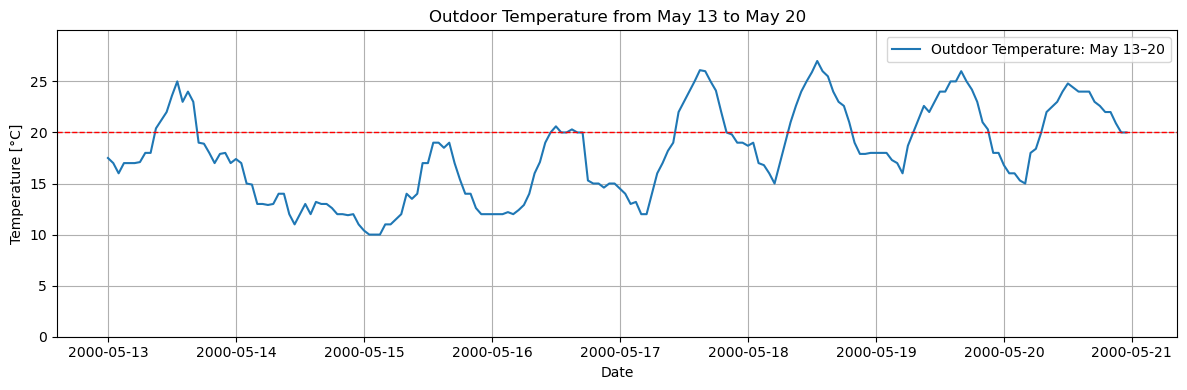

In [11]:
#%% Weekly

# Filter for the specific week: May 13 to May 20 
start_date = "2000-05-13"
end_date = "2000-05-20"
week_data = input_data_proj.loc[start_date:end_date]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(week_data.index, week_data['To'], label='Outdoor Temperature: May 13–20', color='tab:blue')
plt.ylabel('Temperature [°C]')
plt.xlabel('Date')
plt.title('Outdoor Temperature from May 13 to May 20')
plt.grid(True)
plt.legend()

# Add horizontal line at 20°C
plt.axhline(y=20, color='red', linestyle='--', linewidth=1, label='20 °C')
# Set fixed y-axis scale with 5°C steps from 0
plt.ylim(0, 30)
plt.yticks(np.arange(0, 30, 5))

plt.tight_layout()
plt.show()


## 2. Validating the model
In order to validate the model, it was simulated over one week. The following code is explained in detail in the notebook research_project, wehre it is used to simulate one full year. The following section simulated the model over the chosen week in may

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem 
from dm4bem import read_epw, sol_rad_tilt_surf

#%% INPUTS

# Wall dimensions
l = 4 # length of wall
Sf = 8   # surface area of concrete/glass wall (glass part) 
Sc_1 = Si_1 = l**2 - Sf  # surface area of concrete/glass wall (concrete part) 

Sc = Si = 5 * l**2 # surface area of all other full concrete/insulation walls

Sf/Sc_1 # fenestration / wall ratio of wall 1

# Controller
Kp = 0 # free running

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc}                  # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Si}                # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': Sf}                     # m²

# wall that is partly glass:
concrete_1 = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc_1}                # m²

insulation_1 = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Si_1}              # m²



wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass,
                               'Layer_out_1': concrete_1,
                               'Layer_in_1': insulation_1},
                              orient='index')
wall


# physical properties of air
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

# CONVECTION 
h = pd.DataFrame([{'in': 10., 'out': 20}], index=['h'])  # W/(m²⋅K)
h

#%% RADIATIVE PROPERTIES

ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant


# %% CONDUCTANCES

# calculates the conduction using all rows and columns in the dataframe
# creates another column which is conductances
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])


# %% CONVECTION

# formulas for convection, does not calculate yet
Gw = h * wall['Surface'].iloc[0]     # walls 100% concrete/insulation
Gg = h * wall['Surface'].iloc[2]     # glass
Gw_1 = h * wall['Surface'].iloc[3]  # concrete part of glass wall

# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (2 * G_cd['Glass'])))

# %% VIEW FACTORS GLASS / OTHER WALLS

Fwg = glass['Surface'] / concrete['Surface']

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

# WHICH MAKES THE CONDUCTANCE FOR THE HEAT EXCHANGE: (q 5)
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot  # q 10 ventilation


# %% THERMAL CAPACITIES

# walls
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

# air
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

# %% START OF MATRIES ETC:
  
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8', 'θ9', 'θ10', 'θ11']
nθ = 12
θ = [f'θ{i}' for i in range(12)]

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13, q14', 'q15', 'q16']
nq = 17
q = [f'q{i}' for i in range(17)]


# %%incidence matrix A

A = np.zeros([17, 12])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

A[12, 5], A[12, 8] = 1, -1  # branch 12: node 8 -> node 5
A[13, 8], A[13, 9] = 1, -1  # branch 13: node 9 -> node 8
A[14, 9], A[14, 10] = 1, -1  # branch 14: node 10 -> node 9
A[15, 10], A[15, 11] = 1, -1  # branch 15: node 11 -> node 10
A[16, 11] = 1                # branch 16: -> node 11

pd.DataFrame(A, index=q, columns=θ)
# print(A)

# %% conductance matrix

G = np.array(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     2 * G_cd['Glass'],
     Gv,
     Kp,
     2 * G_cd['Layer_in_1'], 2 * G_cd['Layer_in_1'],
     2 * G_cd['Layer_out_1'], 2 * G_cd['Layer_out_1'],
     Gw_1['out']]))

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

# %% capacity matrix
neglect_air_glass = False

if neglect_air_glass:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0, C['Layer_in_1'], 0, C['Layer_out_1'], 0])
else:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  C['Air'], C['Glass'], C['Layer_in_1'], 0, C['Layer_out_1'], 0])

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

#%% temperature source vector (same amountas branches)

b = pd.Series(['To', 0, 0, 0, 0, 0, 0, 0, 'To', 0, 'To', 'Ti_sp', 0, 0, 0, 0, 'To'],
              index=q)

# flow source vector - lenght as nodes.
f = pd.Series(['Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Φa', 0, 0, 0, 'Φo'],
              index=θ)


#%% OUTPUTS
y = np.zeros(12)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

#%% CREATION OF DATAFRAME and TC (can also be read from csv) and steady state

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

# TC['G']['q11'] = 1e3  # Kp -> ∞, almost perfect controller
# TC['G']['q11'] = 0      # Kp -> 0, no controller (free-floating)

# state space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
us

bss = np.zeros(17)        # temperature sources b for steady state
bss[[0, 8, 10, 16]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(12)         # flow-rate sources f for steady state
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

# test of steady state - OK all 10 degrees
θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

# %% Eigenvalues and timestep

λ = np.linalg.eig(As)[0]
Δtmax = 2 * min(-1./λ)
dm4bem.print_rounded_time('Δtmax', Δtmax)

dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)

# settling time
t_settle = 4 * max(-1/ λ) 
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

tau = -1/λ  # time constant
print(tau)


# %% Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_proj = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_proj)

# %%
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T


#%% MÅSTE KÖRAS HÄRIFRÅN FÖR ATT INTE SKRIVA ÖVER TI_SP
controller = True
Kp = 1e3   # W/°C, controller gain

neglect_air_capacity = False
neglect_glass_capacity = False

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step 

# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('TC_project_05.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass)

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)


# INPUT DATA SET
# ==============
input_data_set_week_may = pd.read_csv('input_data_set_week_may.csv',
                             index_col=0,
                             parse_dates=True)
input_data_set_week_may

# %%
# resample data se

input_data_set_week_may = input_data_set_week_may.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set_week_may.head()


# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set_week_may)
u.head()

# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0


I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y = (Cs @ θ.T + Ds @  u.T).T


Kp = TC['G']['q11']     # controller gain
S = 16                  # m², surface area of the toy house
q_HVAC = Kp * (u['q11'] - y['θ6']) / S  # W/m²
y['θ6']


data = pd.DataFrame({'To': input_data_set_week_may['To'],
                     'θi': y['θ6'],
                     'Etot': input_data_set_week_may['Etot'],
                     'q_HVAC': q_HVAC})

# %% Calculate total HVAC energy use
dt_hours = dt / 3600  # convert timestep to hours

heating_power = q_HVAC.clip(lower=0)  # only positive values (heating)
cooling_power = -q_HVAC.clip(upper=0) # only positive cooling power (negate negatives)

E_heating_Wh = (heating_power * S * dt_hours).sum()
E_cooling_Wh = (cooling_power * S * dt_hours).sum()

E_heating_kWh = E_heating_Wh / 1000
E_cooling_kWh = E_cooling_Wh / 1000

print(f"Heating energy use: {E_heating_kWh:.2f} kWh")
print(f"Cooling energy use: {E_cooling_kWh:.2f} kWh")


θss = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.] °C
Δtmax = 885 s = 14.8 min
dt = 600 s = 10.0 min
t_settle = 192310 s = 53.4 h
duration = 194400 s = 54.0 h
[  442.80935179  3851.56350799  4293.64834209  7477.58949611
 48077.55147644 47452.29664406]
A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7   θ8   θ9  θ10  θ11
q0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q5   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
q6   0.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
q7   0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0
q8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
q9   0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.0  0.0  0.0  0.0  0.0
q10  0.0  0.0  0.0  0.0  0.0  0.0  1

/var/folders/lw/p40z617d473_8flqqvkf030w0000gn/T/ipykernel_41073/2970977552.py:370: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  input_data_set_week_may = input_data_set_week_may.resample(


Heating energy use: 19.32 kWh
Cooling energy use: 28.77 kWh


## 2.1 Plotting the controller behaviour
The following section plots controller behaviour with anighttime setback over the chosen week. The graph also illustrates the solar radiation in order to identify if the heating/cooling demand is affected by fluctuations in solar radiation. The previous code can also be run without a controller and then be used to create a graph that can be compared to the following one:

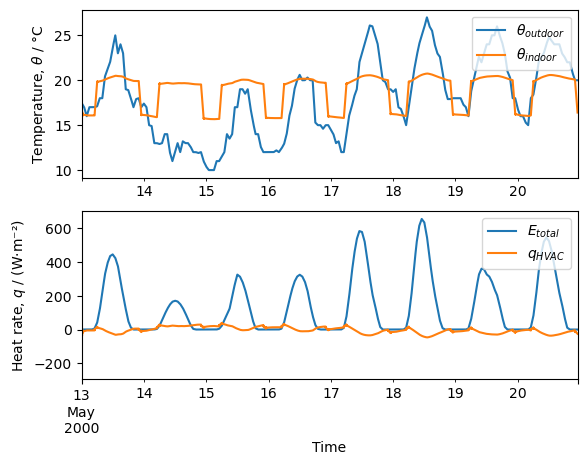

In [23]:
# %% plotting using pandas:

fig, axs = plt.subplots(2, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')

plt.show();

It was noted that the heating and cooling demand wa quite low for the week and difficult to read from the graph. The q_HVAC was therefore plotted alone with the following code where heating values are coloured red and cooling blue: 

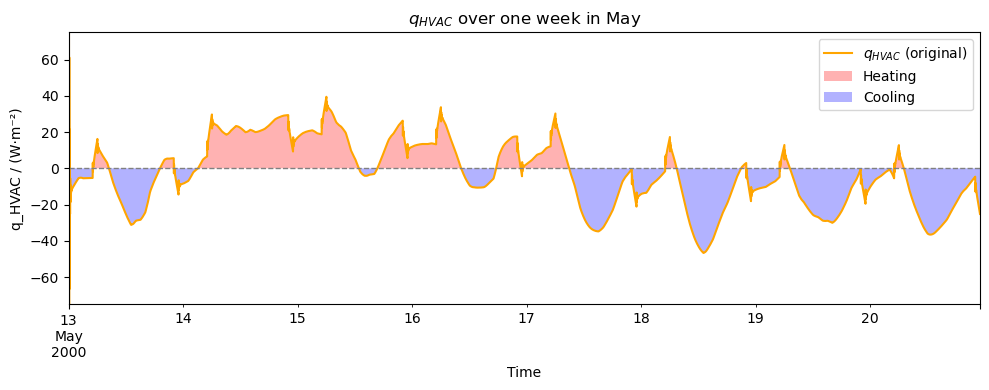

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

# Plot the original q_HVAC line
data['q_HVAC'].plot(ax=ax, label='$q_{HVAC}$ (original)', color='orange')

# Horizontal line at 0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Fill positive values (heating) in red
ax.fill_between(data.index, data['q_HVAC'], 0,
                where=(data['q_HVAC'] > 0),
                facecolor='red', alpha=0.3, interpolate=True, label='Heating')

# Fill negative values (cooling) in blue
ax.fill_between(data.index, data['q_HVAC'], 0,
                where=(data['q_HVAC'] < 0),
                facecolor='blue', alpha=0.3, interpolate=True, label='Cooling')

# Manual y-axis scale
ax.set_ylim(-75, 75)

# Labels and legend
ax.set_title('$q_{HVAC}$ over one week in May')
ax.set_ylabel('q_HVAC / (W·m⁻²)')
ax.set_xlabel('Time')
ax.legend()
plt.tight_layout()
plt.show()